In [1]:
import os
import sys
from datetime import UTC, datetime
from pathlib import Path

from gw2ml import DatabaseClient, database  # noqa: E402


In [2]:
client = DatabaseClient.from_env()

# interesting items:
# 19702: "Platinum Ore"
# 19721: "Ectoplasm"
# 46738: "Deldrimor Steel Ingot"
# 19723: "Green Wood Log"
# 24467: "Tiger's Eye Pebble"


ITEM_ID = int(os.getenv("NOTEBOOK_ITEM_ID", "69665"))
ITEM_ID

69665

In [3]:
prices = database.get_prices(
    client,
    item_id=ITEM_ID,
    start_time=datetime(2025, 11, 1, tzinfo=UTC),
    order="DESC",
)

prices.head()

,id,item_id,whitelisted,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,fetched_at,created_at
0,1033533320,69665,False,69,345645,58,525421,2025-12-22 17:21:43.626974+00:00,2025-12-22 17:21:43.626974+00:00
1,1033505462,69665,False,69,345645,58,525421,2025-12-22 17:16:59.224682+00:00,2025-12-22 17:16:59.224682+00:00
2,1033478204,69665,False,69,345645,58,525421,2025-12-22 17:12:05.249103+00:00,2025-12-22 17:12:05.249103+00:00
3,1033451346,69665,False,69,345645,58,525421,2025-12-22 17:06:38.496322+00:00,2025-12-22 17:06:38.496322+00:00
4,1033424488,69665,False,69,345645,58,525421,2025-12-22 17:01:48.659254+00:00,2025-12-22 17:01:48.659254+00:00


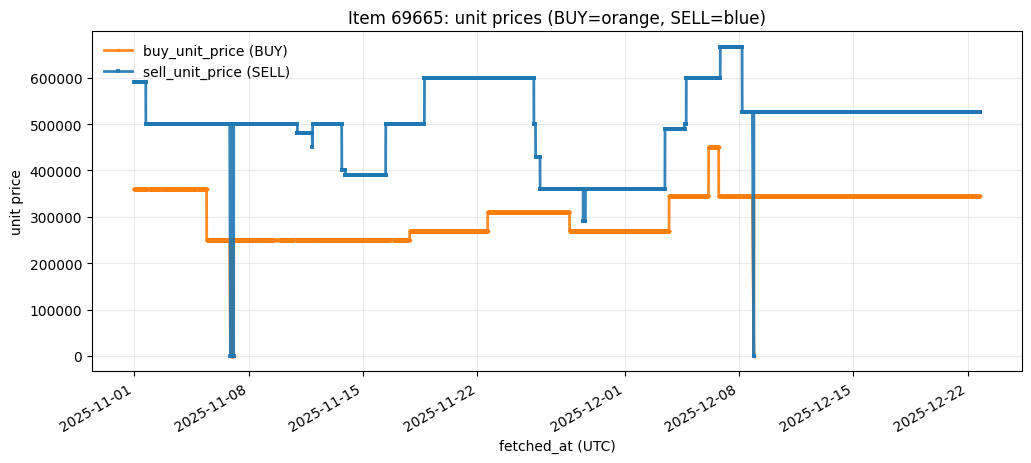

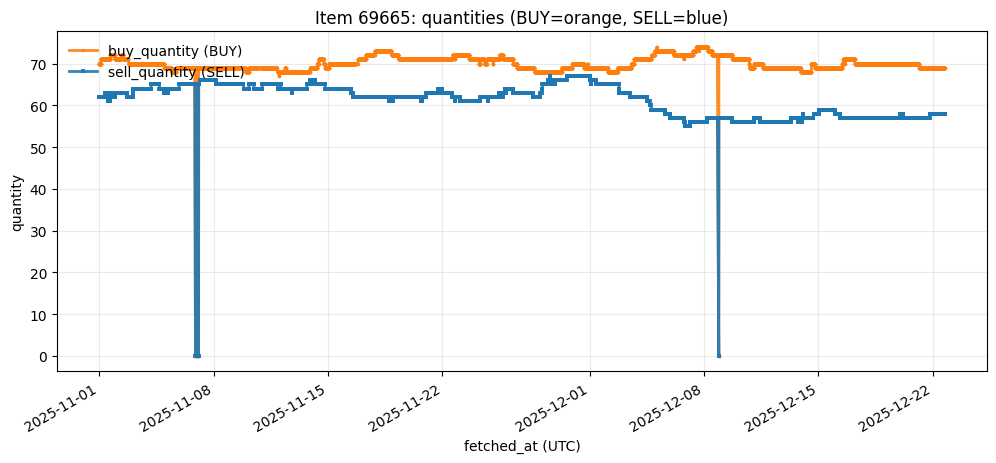

In [4]:
# basic line plots (two figures)
import matplotlib.pyplot as plt

plot_df = prices.sort_values("fetched_at").copy()

BUY_COLOR = "tab:orange"
SELL_COLOR = "tab:blue"

# --- Prices ---
fig_price, ax_price = plt.subplots(figsize=(12, 5))

ax_price.plot(
    plot_df["fetched_at"],
    plot_df["buy_unit_price"],
    label="buy_unit_price (BUY)",
    color=BUY_COLOR,
    linewidth=2,
    marker="o",
    markersize=2.5,
    markeredgewidth=0,
    alpha=0.9,
)
ax_price.plot(
    plot_df["fetched_at"],
    plot_df["sell_unit_price"],
    label="sell_unit_price (SELL)",
    color=SELL_COLOR,
    linewidth=2,
    marker="s",
    markersize=2.5,
    markeredgewidth=0,
    alpha=0.9,
)

ax_price.set_xlabel("fetched_at (UTC)")
ax_price.set_ylabel("unit price")
ax_price.grid(True, alpha=0.25)
ax_price.legend(loc="upper left", frameon=False)
fig_price.autofmt_xdate()
ax_price.set_title(f"Item {ITEM_ID}: unit prices (BUY=orange, SELL=blue)")
plt.show()

# --- Quantities ---
fig_qty, ax_qty = plt.subplots(figsize=(12, 5))

ax_qty.plot(
    plot_df["fetched_at"],
    plot_df["buy_quantity"],
    label="buy_quantity (BUY)",
    color=BUY_COLOR,
    linewidth=2,
    marker="o",
    markersize=2.5,
    markeredgewidth=0,
    alpha=0.9,
)
ax_qty.plot(
    plot_df["fetched_at"],
    plot_df["sell_quantity"],
    label="sell_quantity (SELL)",
    color=SELL_COLOR,
    linewidth=2,
    marker="s",
    markersize=2.5,
    markeredgewidth=0,
    alpha=0.9,
)

ax_qty.set_xlabel("fetched_at (UTC)")
ax_qty.set_ylabel("quantity")
ax_qty.grid(True, alpha=0.25)
ax_qty.legend(loc="upper left", frameon=False)
fig_qty.autofmt_xdate()
ax_qty.set_title(f"Item {ITEM_ID}: quantities (BUY=orange, SELL=blue)")
plt.show()


In [5]:
# Investigate "zeroing" / spikes: find exact timestamps + surrounding rows
from IPython.display import display

plot_df2 = prices.sort_values("fetched_at").reset_index(drop=True).copy()

cols_to_check = [
    "buy_quantity",
    "sell_quantity",
    "buy_unit_price",
    "sell_unit_price",
]

missing_cols = [col for col in cols_to_check if col not in plot_df2.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns: {missing_cols}")

zero_or_negative_mask = False
for col in cols_to_check:
    zero_or_negative_mask = zero_or_negative_mask | (plot_df2[col] <= 0)

anomaly_rows = plot_df2.loc[
    zero_or_negative_mask,
    [
        "fetched_at",
        "id",
        "item_id",
        "buy_quantity",
        "sell_quantity",
        "buy_unit_price",
        "sell_unit_price",
        "whitelisted",
    ],
].sort_values("fetched_at")

if anomaly_rows.empty:
    print("No <= 0 values found in quantity/price columns.")
    min_buy_pos = int(plot_df2["buy_quantity"].idxmin())
    min_sell_pos = int(plot_df2["sell_quantity"].idxmin())
    print("Lowest buy_quantity row:")
    display(plot_df2.iloc[[min_buy_pos]][["fetched_at"] + cols_to_check])
    print("Lowest sell_quantity row:")
    display(plot_df2.iloc[[min_sell_pos]][["fetched_at"] + cols_to_check])
else:
    print("Found rows with <= 0 values (these cause the drop-to-zero effect):")
    display(anomaly_rows)

    # Show a small window around each anomaly to see what changed
    window = 3
    positions = anomaly_rows.index.to_list()
    for pos in positions:
        start = max(0, pos - window)
        end = min(len(plot_df2), pos + window + 1)
        print(f"\nContext around position {pos} (rows {start}..{end - 1}):")
        display(plot_df2.iloc[start:end][["fetched_at"] + cols_to_check])



Found rows with <= 0 values (these cause the drop-to-zero effect):


,fetched_at,id,item_id,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price,whitelisted
1394,2025-11-06 21:24:26.769218+00:00,690499789,69665,0,0,0,0,False
1396,2025-11-06 21:50:18.386663+00:00,690549183,69665,0,0,0,0,False
1397,2025-11-06 22:22:08.948112+00:00,690663353,69665,0,0,0,0,False
1401,2025-11-06 22:38:44.761464+00:00,690755735,69665,0,0,0,0,False
1405,2025-11-06 22:56:34.557549+00:00,690852911,69665,0,0,0,0,False
1407,2025-11-06 23:06:25.578503+00:00,690908299,69665,0,0,0,0,False
1408,2025-11-06 23:11:36.649865+00:00,690934899,69665,0,0,0,0,False
1413,2025-11-06 23:36:52.139781+00:00,691067869,69665,0,0,0,0,False
1416,2025-11-06 23:57:07.602259+00:00,691176045,69665,0,0,0,0,False
1420,2025-11-07 00:16:27.805097+00:00,691279221,69665,0,0,0,0,False



Context around position 1394 (rows 1391..1397):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1391,2025-11-06 19:18:18.267134+00:00,69,65,250214,499898
1392,2025-11-06 19:24:20.341276+00:00,69,65,250214,499898
1393,2025-11-06 20:20:10.212673+00:00,69,65,250214,499898
1394,2025-11-06 21:24:26.769218+00:00,0,0,0,0
1395,2025-11-06 21:33:40.529003+00:00,69,65,250214,499898
1396,2025-11-06 21:50:18.386663+00:00,0,0,0,0
1397,2025-11-06 22:22:08.948112+00:00,0,0,0,0



Context around position 1396 (rows 1393..1399):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1393,2025-11-06 20:20:10.212673+00:00,69,65,250214,499898
1394,2025-11-06 21:24:26.769218+00:00,0,0,0,0
1395,2025-11-06 21:33:40.529003+00:00,69,65,250214,499898
1396,2025-11-06 21:50:18.386663+00:00,0,0,0,0
1397,2025-11-06 22:22:08.948112+00:00,0,0,0,0
1398,2025-11-06 22:26:33.924437+00:00,69,65,250214,499898
1399,2025-11-06 22:29:40.590143+00:00,69,65,250214,499898



Context around position 1397 (rows 1394..1400):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1394,2025-11-06 21:24:26.769218+00:00,0,0,0,0
1395,2025-11-06 21:33:40.529003+00:00,69,65,250214,499898
1396,2025-11-06 21:50:18.386663+00:00,0,0,0,0
1397,2025-11-06 22:22:08.948112+00:00,0,0,0,0
1398,2025-11-06 22:26:33.924437+00:00,69,65,250214,499898
1399,2025-11-06 22:29:40.590143+00:00,69,65,250214,499898
1400,2025-11-06 22:34:45.921793+00:00,69,65,250214,499898



Context around position 1401 (rows 1398..1404):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1398,2025-11-06 22:26:33.924437+00:00,69,65,250214,499898
1399,2025-11-06 22:29:40.590143+00:00,69,65,250214,499898
1400,2025-11-06 22:34:45.921793+00:00,69,65,250214,499898
1401,2025-11-06 22:38:44.761464+00:00,0,0,0,0
1402,2025-11-06 22:40:50.981680+00:00,69,65,250214,499898
1403,2025-11-06 22:46:44.632915+00:00,69,65,250214,499898
1404,2025-11-06 22:51:33.409266+00:00,69,65,250214,499898



Context around position 1405 (rows 1402..1408):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1402,2025-11-06 22:40:50.981680+00:00,69,65,250214,499898
1403,2025-11-06 22:46:44.632915+00:00,69,65,250214,499898
1404,2025-11-06 22:51:33.409266+00:00,69,65,250214,499898
1405,2025-11-06 22:56:34.557549+00:00,0,0,0,0
1406,2025-11-06 23:02:55.492007+00:00,69,65,250214,499898
1407,2025-11-06 23:06:25.578503+00:00,0,0,0,0
1408,2025-11-06 23:11:36.649865+00:00,0,0,0,0



Context around position 1407 (rows 1404..1410):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1404,2025-11-06 22:51:33.409266+00:00,69,65,250214,499898
1405,2025-11-06 22:56:34.557549+00:00,0,0,0,0
1406,2025-11-06 23:02:55.492007+00:00,69,65,250214,499898
1407,2025-11-06 23:06:25.578503+00:00,0,0,0,0
1408,2025-11-06 23:11:36.649865+00:00,0,0,0,0
1409,2025-11-06 23:16:34.812928+00:00,69,65,250214,499898
1410,2025-11-06 23:22:00.636521+00:00,69,65,250214,499898



Context around position 1408 (rows 1405..1411):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1405,2025-11-06 22:56:34.557549+00:00,0,0,0,0
1406,2025-11-06 23:02:55.492007+00:00,69,65,250214,499898
1407,2025-11-06 23:06:25.578503+00:00,0,0,0,0
1408,2025-11-06 23:11:36.649865+00:00,0,0,0,0
1409,2025-11-06 23:16:34.812928+00:00,69,65,250214,499898
1410,2025-11-06 23:22:00.636521+00:00,69,65,250214,499898
1411,2025-11-06 23:26:25.711409+00:00,69,65,250214,499898



Context around position 1413 (rows 1410..1416):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1410,2025-11-06 23:22:00.636521+00:00,69,65,250214,499898
1411,2025-11-06 23:26:25.711409+00:00,69,65,250214,499898
1412,2025-11-06 23:32:00.634029+00:00,69,65,250214,499898
1413,2025-11-06 23:36:52.139781+00:00,0,0,0,0
1414,2025-11-06 23:41:28.424038+00:00,69,65,250214,499898
1415,2025-11-06 23:52:23.918396+00:00,69,65,250214,499898
1416,2025-11-06 23:57:07.602259+00:00,0,0,0,0



Context around position 1416 (rows 1413..1419):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1413,2025-11-06 23:36:52.139781+00:00,0,0,0,0
1414,2025-11-06 23:41:28.424038+00:00,69,65,250214,499898
1415,2025-11-06 23:52:23.918396+00:00,69,65,250214,499898
1416,2025-11-06 23:57:07.602259+00:00,0,0,0,0
1417,2025-11-07 00:02:53.678486+00:00,69,65,250214,499898
1418,2025-11-07 00:06:32.590154+00:00,69,65,250214,499898
1419,2025-11-07 00:11:24.245675+00:00,69,65,250214,499898



Context around position 1420 (rows 1417..1423):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1417,2025-11-07 00:02:53.678486+00:00,69,65,250214,499898
1418,2025-11-07 00:06:32.590154+00:00,69,65,250214,499898
1419,2025-11-07 00:11:24.245675+00:00,69,65,250214,499898
1420,2025-11-07 00:16:27.805097+00:00,0,0,0,0
1421,2025-11-07 00:21:38.626467+00:00,69,65,250214,499898
1422,2025-11-07 00:26:09.881452+00:00,69,65,250214,499898
1423,2025-11-07 00:36:18.961495+00:00,69,65,250214,499898



Context around position 1430 (rows 1427..1433):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1427,2025-11-07 00:56:45.722256+00:00,69,65,250214,499898
1428,2025-11-07 01:01:48.108389+00:00,69,65,250214,499898
1429,2025-11-07 01:11:03.339468+00:00,69,65,250214,499898
1430,2025-11-07 01:16:17.311160+00:00,0,0,0,0
1431,2025-11-07 01:31:31.146860+00:00,69,65,250214,499898
1432,2025-11-07 01:36:32.121029+00:00,69,65,250214,499898
1433,2025-11-07 01:41:23.425461+00:00,69,65,250214,499898



Context around position 1434 (rows 1431..1437):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1431,2025-11-07 01:31:31.146860+00:00,69,65,250214,499898
1432,2025-11-07 01:36:32.121029+00:00,69,65,250214,499898
1433,2025-11-07 01:41:23.425461+00:00,69,65,250214,499898
1434,2025-11-07 01:46:04.252448+00:00,0,0,0,0
1435,2025-11-07 01:51:26.269695+00:00,0,0,0,0
1436,2025-11-07 02:01:57.550123+00:00,0,0,0,0
1437,2025-11-07 02:06:27.740536+00:00,69,65,250214,499898



Context around position 1435 (rows 1432..1438):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1432,2025-11-07 01:36:32.121029+00:00,69,65,250214,499898
1433,2025-11-07 01:41:23.425461+00:00,69,65,250214,499898
1434,2025-11-07 01:46:04.252448+00:00,0,0,0,0
1435,2025-11-07 01:51:26.269695+00:00,0,0,0,0
1436,2025-11-07 02:01:57.550123+00:00,0,0,0,0
1437,2025-11-07 02:06:27.740536+00:00,69,65,250214,499898
1438,2025-11-07 02:11:15.574477+00:00,69,65,250214,499898



Context around position 1436 (rows 1433..1439):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
1433,2025-11-07 01:41:23.425461+00:00,69,65,250214,499898
1434,2025-11-07 01:46:04.252448+00:00,0,0,0,0
1435,2025-11-07 01:51:26.269695+00:00,0,0,0,0
1436,2025-11-07 02:01:57.550123+00:00,0,0,0,0
1437,2025-11-07 02:06:27.740536+00:00,69,65,250214,499898
1438,2025-11-07 02:11:15.574477+00:00,69,65,250214,499898
1439,2025-11-07 02:16:20.975740+00:00,69,65,250214,499898



Context around position 9929 (rows 9926..9932):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
9926,2025-12-08 19:32:02.134557+00:00,72,57,345422,525421
9927,2025-12-08 19:36:01.763125+00:00,72,57,345422,525421
9928,2025-12-08 19:41:52.543675+00:00,72,57,345422,525421
9929,2025-12-08 21:44:28.004506+00:00,0,0,0,0
9930,2025-12-08 21:45:23.681301+00:00,0,0,0,0
9931,2025-12-08 21:45:36.217762+00:00,0,0,0,0
9932,2025-12-08 21:51:24.460315+00:00,72,57,345422,525421



Context around position 9930 (rows 9927..9933):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
9927,2025-12-08 19:36:01.763125+00:00,72,57,345422,525421
9928,2025-12-08 19:41:52.543675+00:00,72,57,345422,525421
9929,2025-12-08 21:44:28.004506+00:00,0,0,0,0
9930,2025-12-08 21:45:23.681301+00:00,0,0,0,0
9931,2025-12-08 21:45:36.217762+00:00,0,0,0,0
9932,2025-12-08 21:51:24.460315+00:00,72,57,345422,525421
9933,2025-12-08 21:56:34.313163+00:00,72,57,345422,525421



Context around position 9931 (rows 9928..9934):


,fetched_at,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
9928,2025-12-08 19:41:52.543675+00:00,72,57,345422,525421
9929,2025-12-08 21:44:28.004506+00:00,0,0,0,0
9930,2025-12-08 21:45:23.681301+00:00,0,0,0,0
9931,2025-12-08 21:45:36.217762+00:00,0,0,0,0
9932,2025-12-08 21:51:24.460315+00:00,72,57,345422,525421
9933,2025-12-08 21:56:34.313163+00:00,72,57,345422,525421
9934,2025-12-08 22:01:14.117880+00:00,72,57,345422,525421


In [6]:
# remove zero values (AFTER inspection) so we can work with cleaned data afterwards
from IPython.display import display

cols_all_zero = [
    "buy_quantity",
    "sell_quantity",
    "buy_unit_price",
    "sell_unit_price",
]

prices_sorted = prices.sort_values("fetched_at").copy()
all_zero_mask = (prices_sorted[cols_all_zero] == 0).all(axis=1)

all_zero_rows = prices_sorted.loc[
    all_zero_mask,
    ["fetched_at", "id", "item_id"] + cols_all_zero,
].sort_values("fetched_at")

if all_zero_rows.empty:
    print("No rows found where all metrics are 0.")
else:
    print(f"Dropping {len(all_zero_rows)} rows where all metrics are 0 (kept in `all_zero_rows`).")
    display(all_zero_rows)

# Cleaned dataframe you can use for plotting/modeling/etc.
prices_clean = prices_sorted.loc[~all_zero_mask].copy()

print(f"prices rows: {len(prices_sorted)}")
print(f"prices_clean rows: {len(prices_clean)}")



Dropping 17 rows where all metrics are 0 (kept in `all_zero_rows`).


,fetched_at,id,item_id,buy_quantity,sell_quantity,buy_unit_price,sell_unit_price
12313,2025-11-06 21:24:26.769218+00:00,690499789,69665,0,0,0,0
12311,2025-11-06 21:50:18.386663+00:00,690549183,69665,0,0,0,0
12310,2025-11-06 22:22:08.948112+00:00,690663353,69665,0,0,0,0
12306,2025-11-06 22:38:44.761464+00:00,690755735,69665,0,0,0,0
12302,2025-11-06 22:56:34.557549+00:00,690852911,69665,0,0,0,0
12300,2025-11-06 23:06:25.578503+00:00,690908299,69665,0,0,0,0
12299,2025-11-06 23:11:36.649865+00:00,690934899,69665,0,0,0,0
12294,2025-11-06 23:36:52.139781+00:00,691067869,69665,0,0,0,0
12291,2025-11-06 23:57:07.602259+00:00,691176045,69665,0,0,0,0
12287,2025-11-07 00:16:27.805097+00:00,691279221,69665,0,0,0,0


prices rows: 13708
prices_clean rows: 13691


5-minute grid summary:
- buckets total: 14897
- buckets observed: 13498
- buckets missing (all metrics NaN): 1399


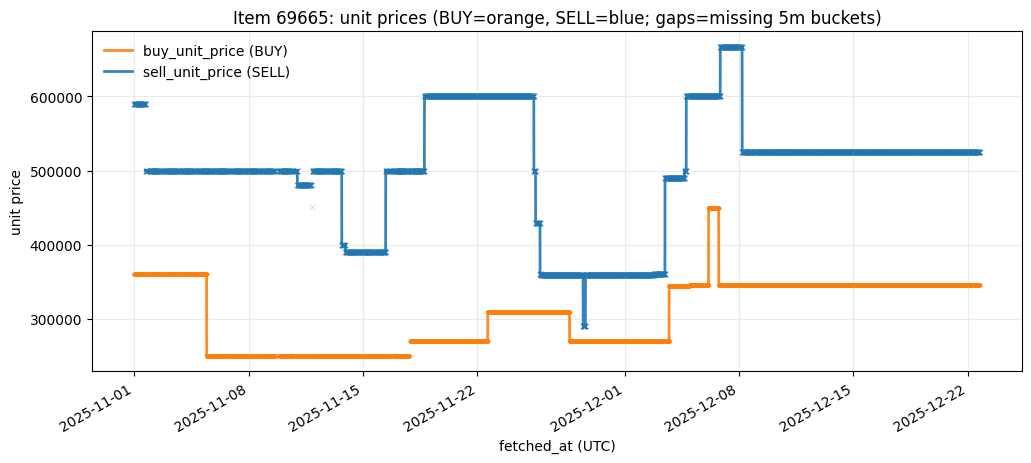

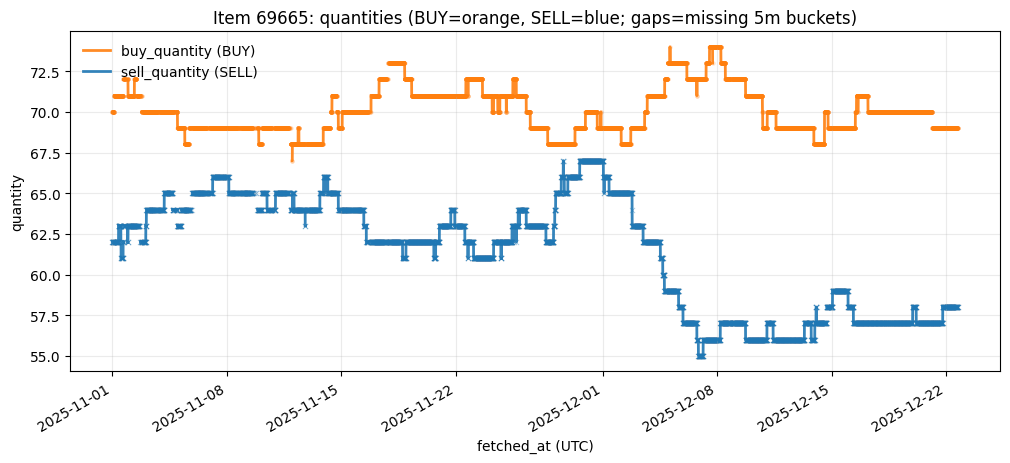

In [7]:
# plot them again (show missing 5-minute buckets as gaps)
import pandas as pd
import matplotlib.pyplot as plt

BUY_COLOR = "tab:orange"
SELL_COLOR = "tab:blue"

cols = ["buy_quantity", "sell_quantity", "buy_unit_price", "sell_unit_price"]

source_df = prices_clean if "prices_clean" in globals() else prices
raw_df = source_df.sort_values("fetched_at").copy()

# Bucket timestamps to a stable grid first (your raw timestamps drift by seconds).
# This makes gaps meaningful and visible.
raw_df["fetched_at_5m"] = raw_df["fetched_at"].dt.floor("5min")

df_5m = (
    raw_df.groupby("fetched_at_5m", as_index=False)[cols]
    .last()
    .sort_values("fetched_at_5m")
    .set_index("fetched_at_5m")
)

regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", name="fetched_at_5m")
plot_regular = df_5m.reindex(regular_index)

missing_5m_buckets = int(plot_regular[cols].isna().all(axis=1).sum())
print("5-minute grid summary:")
print("- buckets total:", len(regular_index))
print("- buckets observed:", df_5m.index.nunique())
print("- buckets missing (all metrics NaN):", missing_5m_buckets)

# --- Prices (gaps visible) ---
fig_price, ax_price = plt.subplots(figsize=(12, 5))
ax_price.plot(
    plot_regular.index,
    plot_regular["buy_unit_price"],
    label="buy_unit_price (BUY)",
    color=BUY_COLOR,
    linewidth=2,
    alpha=0.9,
)
ax_price.plot(
    plot_regular.index,
    plot_regular["sell_unit_price"],
    label="sell_unit_price (SELL)",
    color=SELL_COLOR,
    linewidth=2,
    alpha=0.9,
)

# overlay actual binned points
ax_price.scatter(
    df_5m.index,
    df_5m["buy_unit_price"],
    s=10,
    marker="o",
    color=BUY_COLOR,
    alpha=0.25,
    linewidths=0,
)
ax_price.scatter(
    df_5m.index,
    df_5m["sell_unit_price"],
    s=14,
    marker="x",
    color=SELL_COLOR,
    alpha=0.30,
    linewidths=0.5,
)

ax_price.set_xlabel("fetched_at (UTC)")
ax_price.set_ylabel("unit price")
ax_price.grid(True, alpha=0.25)
ax_price.legend(loc="upper left", frameon=False)
fig_price.autofmt_xdate()
ax_price.set_title(f"Item {ITEM_ID}: unit prices (BUY=orange, SELL=blue; gaps=missing 5m buckets)")
plt.show()

# --- Quantities (gaps visible) ---
fig_qty, ax_qty = plt.subplots(figsize=(12, 5))
ax_qty.plot(
    plot_regular.index,
    plot_regular["buy_quantity"],
    label="buy_quantity (BUY)",
    color=BUY_COLOR,
    linewidth=2,
    alpha=0.9,
)
ax_qty.plot(
    plot_regular.index,
    plot_regular["sell_quantity"],
    label="sell_quantity (SELL)",
    color=SELL_COLOR,
    linewidth=2,
    alpha=0.9,
)

# overlay actual binned points
ax_qty.scatter(
    df_5m.index,
    df_5m["buy_quantity"],
    s=10,
    marker="o",
    color=BUY_COLOR,
    alpha=0.20,
    linewidths=0,
)
ax_qty.scatter(
    df_5m.index,
    df_5m["sell_quantity"],
    s=14,
    marker="x",
    color=SELL_COLOR,
    alpha=0.25,
    linewidths=0.5,
)

ax_qty.set_xlabel("fetched_at (UTC)")
ax_qty.set_ylabel("quantity")
ax_qty.grid(True, alpha=0.25)
ax_qty.legend(loc="upper left", frameon=False)
fig_qty.autofmt_xdate()
ax_qty.set_title(f"Item {ITEM_ID}: quantities (BUY=orange, SELL=blue; gaps=missing 5m buckets)")
plt.show()


In [10]:
# find missing values (and whether it matters for weekly splits)
import pandas as pd

cols = ["buy_quantity", "sell_quantity", "buy_unit_price", "sell_unit_price"]

source_df = prices_clean if "prices_clean" in globals() else prices
raw_df = source_df.sort_values("fetched_at").copy()

# 1) Missing values inside recorded rows (true NaNs)
print("NaNs in recorded rows (by column):")
print(raw_df[cols].isna().sum())

# 2) Missing timestamps (gaps): do this on a stable grid (5-minute buckets)
raw_df["fetched_at_5m"] = raw_df["fetched_at"].dt.floor("5min")
df_5m = (
    raw_df.groupby("fetched_at_5m", as_index=False)[cols]
    .last()
    .sort_values("fetched_at_5m")
    .set_index("fetched_at_5m")
)

regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", name="fetched_at_5m")
regular_5m = df_5m.reindex(regular_index)
missing_5m_mask = regular_5m[cols].isna().all(axis=1)

print("Observed buckets:", df_5m.index.nunique())
print("Missing buckets (all metrics NaN):", int(missing_5m_mask.sum()))

if missing_5m_mask.any():
    print("\nFirst 10 missing 5-minute buckets:")
    print(regular_5m.index[missing_5m_mask][:10])

    # Summarize gap segments (start/end/duration)
    gap_df = pd.DataFrame({"is_missing": missing_5m_mask.astype(int)}, index=regular_5m.index)
    gap_df["grp"] = (gap_df["is_missing"].diff().fillna(0) != 0).cumsum()
    gaps = (
        gap_df[gap_df["is_missing"] == 1]
        .groupby("grp")
        .apply(lambda g: pd.Series({"start": g.index.min(), "end": g.index.max(), "minutes": ((g.index.max() - g.index.min()) / pd.Timedelta(minutes=1)) + 5}))
        .sort_values("minutes", ascending=False)
    )
    print("\nTop 10 longest missing segments (minutes):")
    print(gaps.head(10))

# 3) Weekly splits: you generally don't need to fill gaps, but DO filter partial/low-coverage weeks.
# Use the 5-minute grid so coverage is comparable week-to-week.
weekly = (
    regular_5m.assign(observed=(~missing_5m_mask).astype(int))
    .resample("W", label="left", closed="left")
    .agg(observed_points=("observed", "sum"))
)

expected_weekly_points = int(pd.Timedelta(days=7) / pd.Timedelta(minutes=5))  # 2016
weekly["expected_points"] = expected_weekly_points
weekly["coverage_pct"] = (weekly["observed_points"] / expected_weekly_points) * 100

print("\nWeekly coverage (lowest first):")
print(weekly.sort_values("coverage_pct").head(10))

# Convenience: drop the first and last week buckets (usually partial at dataset boundaries)
weekly_full_weeks = weekly.iloc[1:-1].copy() if len(weekly) >= 3 else weekly.copy()
print("\nAfter dropping first+last week buckets:")
print(weekly_full_weeks.sort_values("coverage_pct").head(10))


NaNs in recorded rows (by column):
buy_quantity       0
sell_quantity      0
buy_unit_price     0
sell_unit_price    0
dtype: int64
Observed buckets: 13498
Missing buckets (all metrics NaN): 1399

First 10 missing 5-minute buckets:
DatetimeIndex(['2025-11-01 01:15:00+00:00', '2025-11-01 01:45:00+00:00',
               '2025-11-01 02:05:00+00:00', '2025-11-01 02:35:00+00:00',
               '2025-11-01 02:45:00+00:00', '2025-11-01 03:35:00+00:00',
               '2025-11-01 04:30:00+00:00', '2025-11-01 09:20:00+00:00',
               '2025-11-01 12:20:00+00:00', '2025-11-01 12:40:00+00:00'],
              dtype='datetime64[ns, UTC]', name='fetched_at_5m', freq=None)

Top 10 longest missing segments (minutes):
                         start                       end  minutes
grp                                                              
631  2025-11-09 14:15:00+00:00 2025-11-09 16:15:00+00:00    125.0
1433 2025-12-08 19:45:00+00:00 2025-12-08 21:45:00+00:00    125.0
637  2025-11-09 17

/tmp/ipykernel_71283/2389838238.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"start": g.index.min(), "end": g.index.max(), "minutes": ((g.index.max() - g.index.min()) / pd.Timedelta(minutes=1)) + 5}))


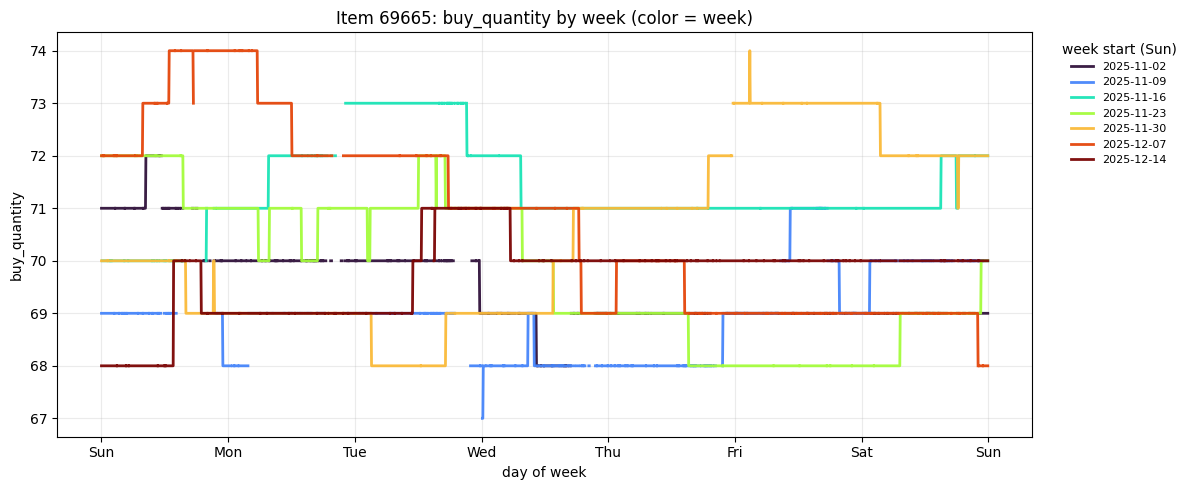

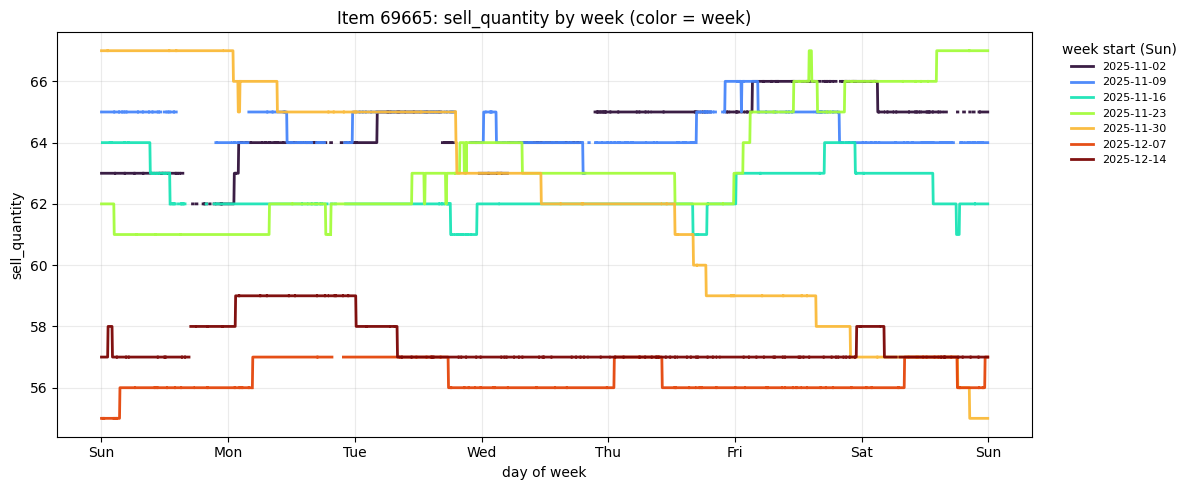

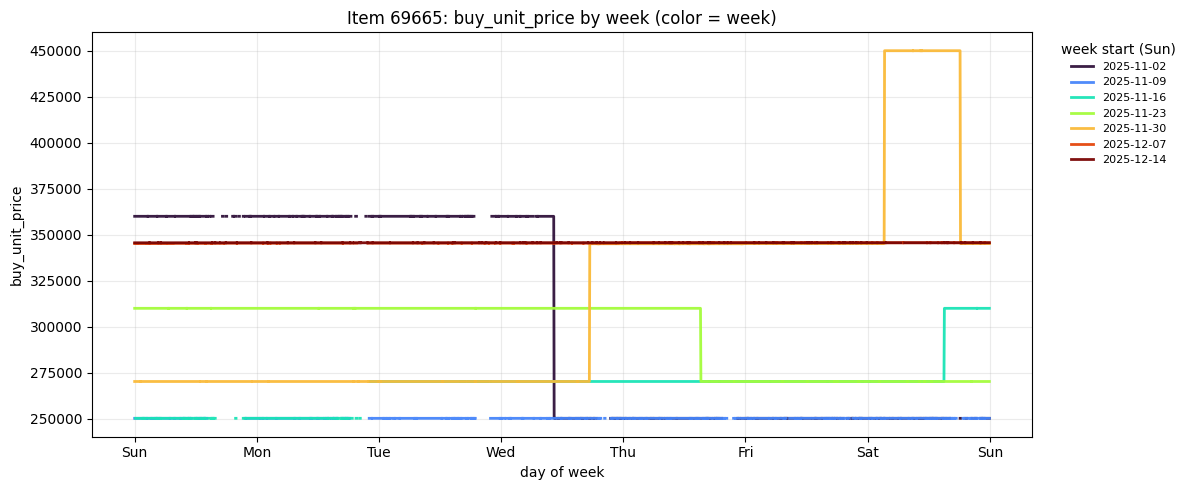

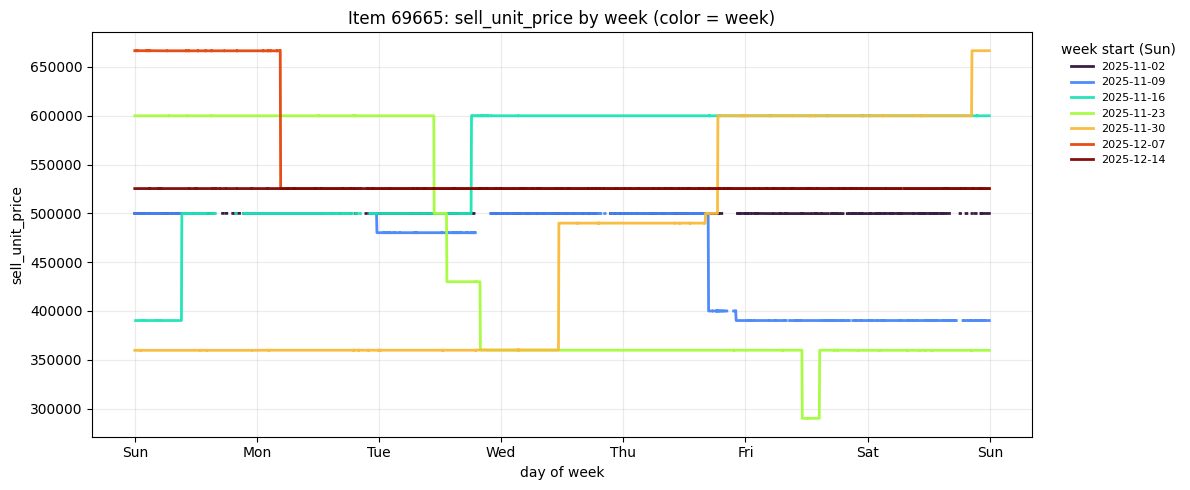

Plotted 7 weeks (INCLUDE_PARTIAL_WEEKS=False).


In [11]:
# weekly grouped line charts (one chart per metric; same week color across all charts)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source_df = prices_clean if "prices_clean" in globals() else prices
raw_df = source_df.sort_values("fetched_at").copy()

metrics = [
    "buy_quantity",
    "sell_quantity",
    "buy_unit_price",
    "sell_unit_price",
]

# 5-minute bucketed series (stable grid)
raw_df["fetched_at_5m"] = raw_df["fetched_at"].dt.floor("5min")
df_5m = (
    raw_df.groupby("fetched_at_5m", as_index=False)[metrics]
    .last()
    .sort_values("fetched_at_5m")
    .set_index("fetched_at_5m")
)

# Define weeks starting on Sunday 00:00 UTC (matches earlier weekly coverage bins)
week_start = (df_5m.index - pd.to_timedelta((df_5m.index.dayofweek + 1) % 7, unit="D")).normalize()
week_starts = pd.Index(week_start.unique()).sort_values()

# Drop first/last (usually partial dataset boundary weeks)
INCLUDE_PARTIAL_WEEKS = False
if not INCLUDE_PARTIAL_WEEKS and len(week_starts) >= 3:
    week_starts = week_starts[1:-1]

if week_starts.empty:
    raise ValueError("No full weeks available to plot (try INCLUDE_PARTIAL_WEEKS=True).")

# Consistent week -> color mapping
cmap = plt.get_cmap("turbo", len(week_starts))
week_to_color = {ws: cmap(i) for i, ws in enumerate(week_starts)}

# X axis: hours since week start (0..168)
hours_per_week = 24 * 7
week_index_len = int(pd.Timedelta(days=7) / pd.Timedelta(minutes=5))  # 2016
x_hours = np.linspace(0, hours_per_week, week_index_len, endpoint=False)
xticks = [0, 24, 48, 72, 96, 120, 144, 168]
xtick_labels = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 5))

    for ws in week_starts:
        we = ws + pd.Timedelta(days=7)
        week_grid = pd.date_range(ws, we - pd.Timedelta(minutes=5), freq="5min", tz=ws.tz)
        week_series = df_5m.loc[(df_5m.index >= ws) & (df_5m.index < we), [metric]].reindex(week_grid)

        ax.plot(
            x_hours,
            week_series[metric].to_numpy(),
            color=week_to_color[ws],
            linewidth=2,
            alpha=0.95,
            label=str(ws.date()),
        )

    ax.set_title(f"Item {ITEM_ID}: {metric} by week (color = week)")
    ax.set_xlabel("day of week")
    ax.set_ylabel(metric)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.grid(True, alpha=0.25)

    # Keep legend readable
    ax.legend(
        title="week start (Sun)",
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=False,
        fontsize=8,
    )

    plt.tight_layout()
    plt.show()

print(f"Plotted {len(week_starts)} weeks (INCLUDE_PARTIAL_WEEKS={INCLUDE_PARTIAL_WEEKS}).")



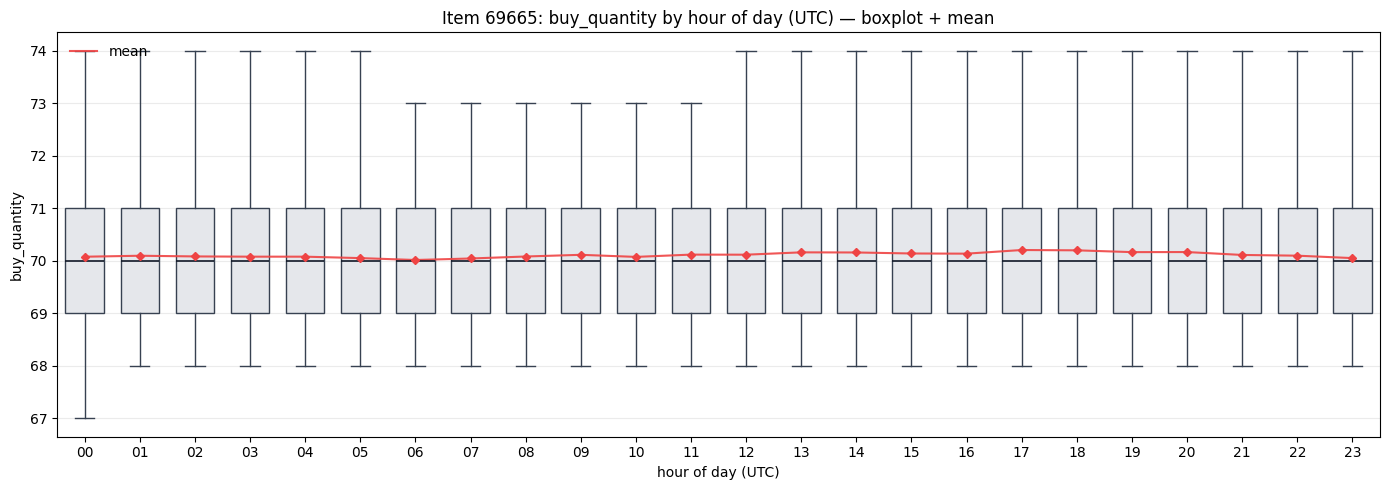

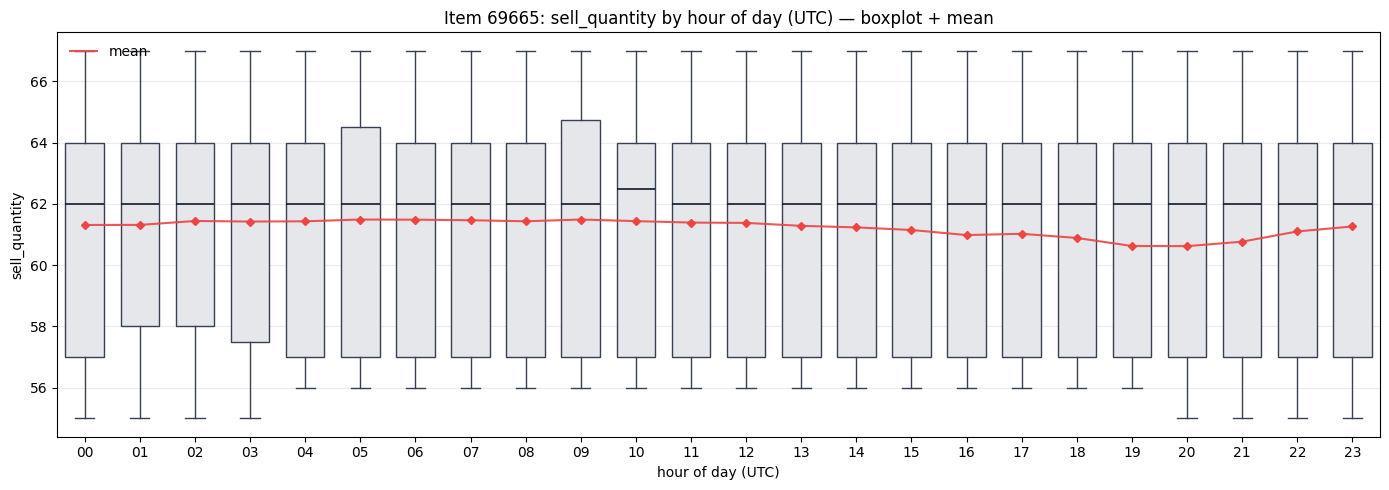

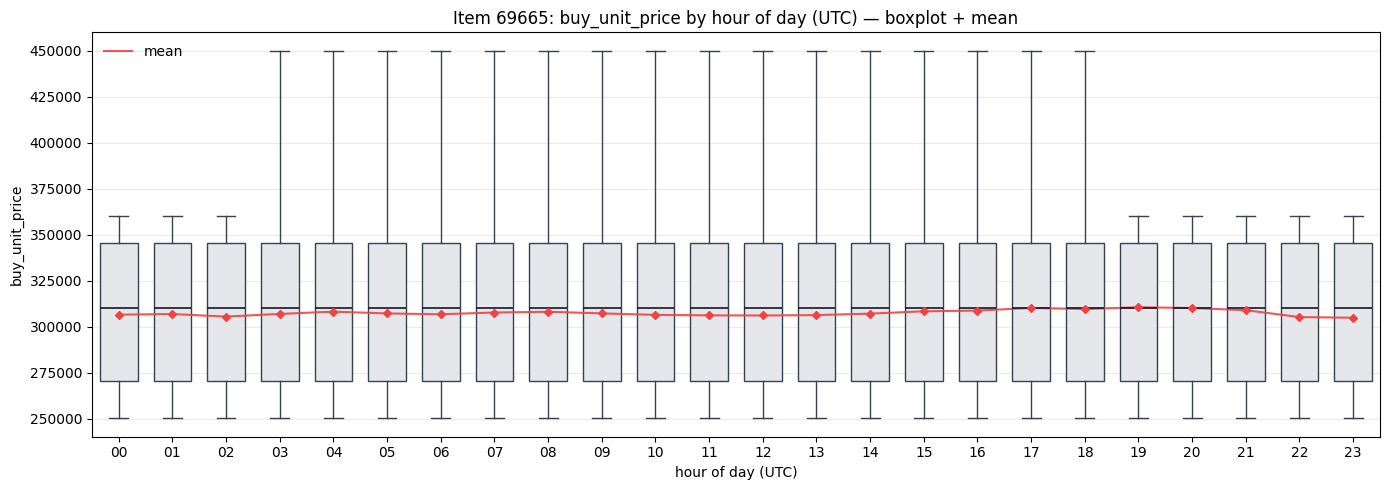

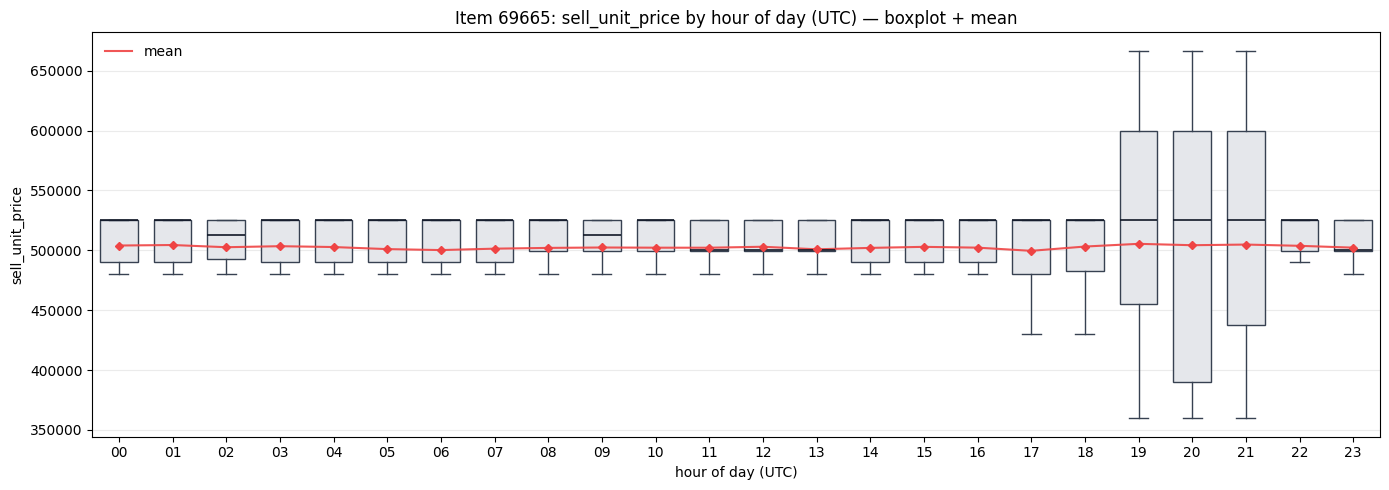

In [12]:
# hourly boxplots (00–23): distribution by hour of day + mean markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source_df = prices_clean if "prices_clean" in globals() else prices
raw_df = source_df.sort_values("fetched_at").copy()

metrics = [
    "buy_quantity",
    "sell_quantity",
    "buy_unit_price",
    "sell_unit_price",
]

# 5-minute bucketed series (stable)
raw_df["fetched_at_5m"] = raw_df["fetched_at"].dt.floor("5min")
df_5m = (
    raw_df.groupby("fetched_at_5m", as_index=False)[metrics]
    .last()
    .sort_values("fetched_at_5m")
    .set_index("fetched_at_5m")
)

df_5m["hour"] = df_5m.index.hour
hours = list(range(24))

for metric in metrics:
    # Collect values per hour (NaNs are automatically ignored by numpy)
    hourly_values = [df_5m.loc[df_5m["hour"] == h, metric].dropna().to_numpy() for h in hours]
    hourly_means = [float(np.mean(v)) if len(v) else np.nan for v in hourly_values]

    fig, ax = plt.subplots(figsize=(14, 5))

    ax.boxplot(
        hourly_values,
        positions=hours,
        widths=0.7,
        showmeans=True,
        meanline=False,
        showfliers=False,
        patch_artist=True,
        boxprops={"facecolor": "#e5e7eb", "edgecolor": "#374151", "linewidth": 1.0},
        medianprops={"color": "#111827", "linewidth": 1.2},
        whiskerprops={"color": "#374151", "linewidth": 1.0},
        capprops={"color": "#374151", "linewidth": 1.0},
        meanprops={"marker": "D", "markerfacecolor": "#ef4444", "markeredgecolor": "#ef4444", "markersize": 4},
    )

    # Overlay mean line for readability
    ax.plot(hours, hourly_means, color="#ef4444", linewidth=1.5, alpha=0.9, label="mean")

    ax.set_title(f"Item {ITEM_ID}: {metric} by hour of day (UTC) — boxplot + mean")
    ax.set_xlabel("hour of day (UTC)")
    ax.set_ylabel(metric)
    ax.set_xticks(hours)
    ax.set_xticklabels([str(h).zfill(2) for h in hours], rotation=0)
    ax.grid(True, axis="y", alpha=0.25)
    ax.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    plt.show()



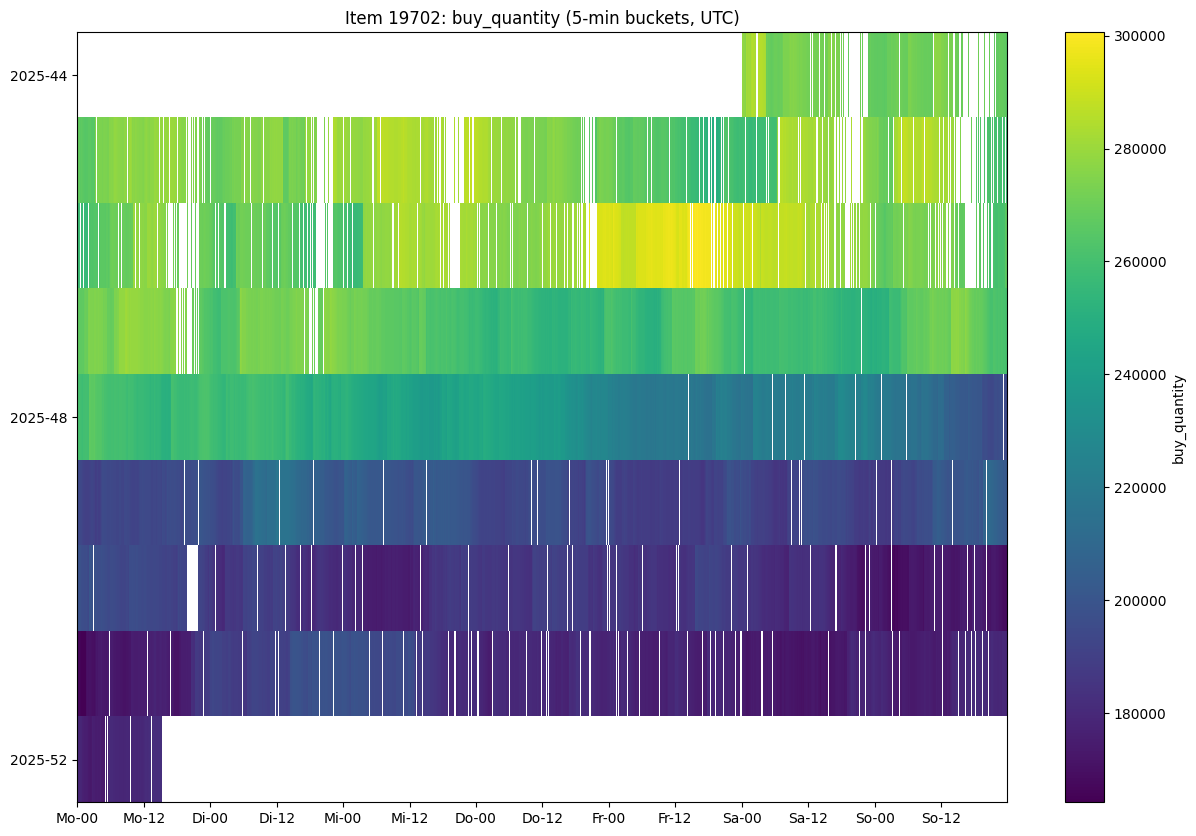

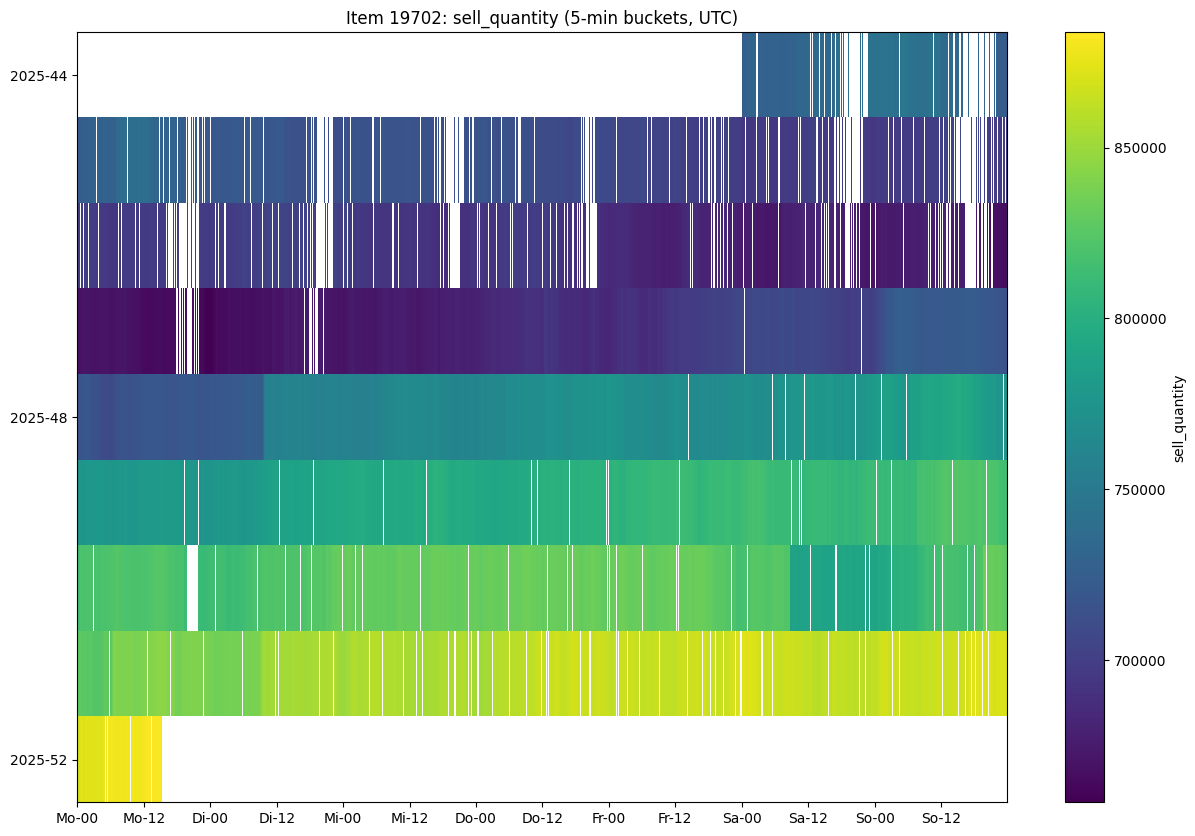

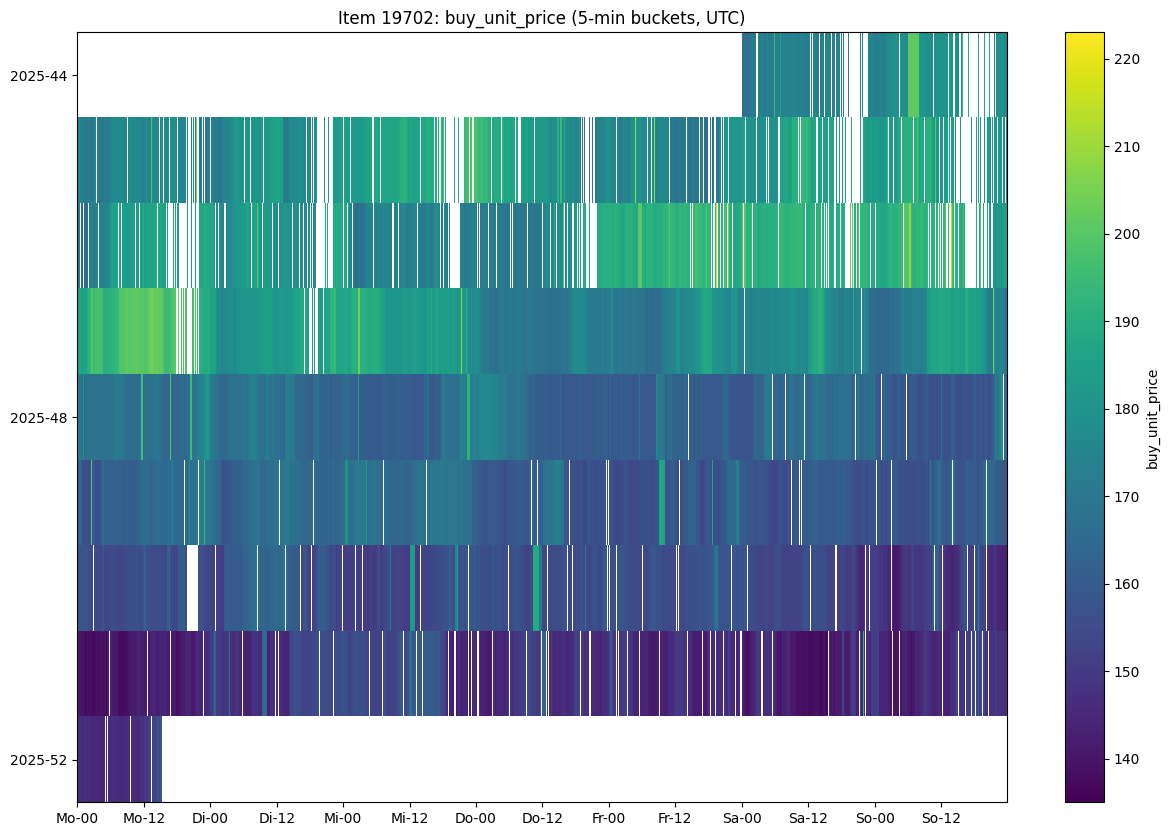

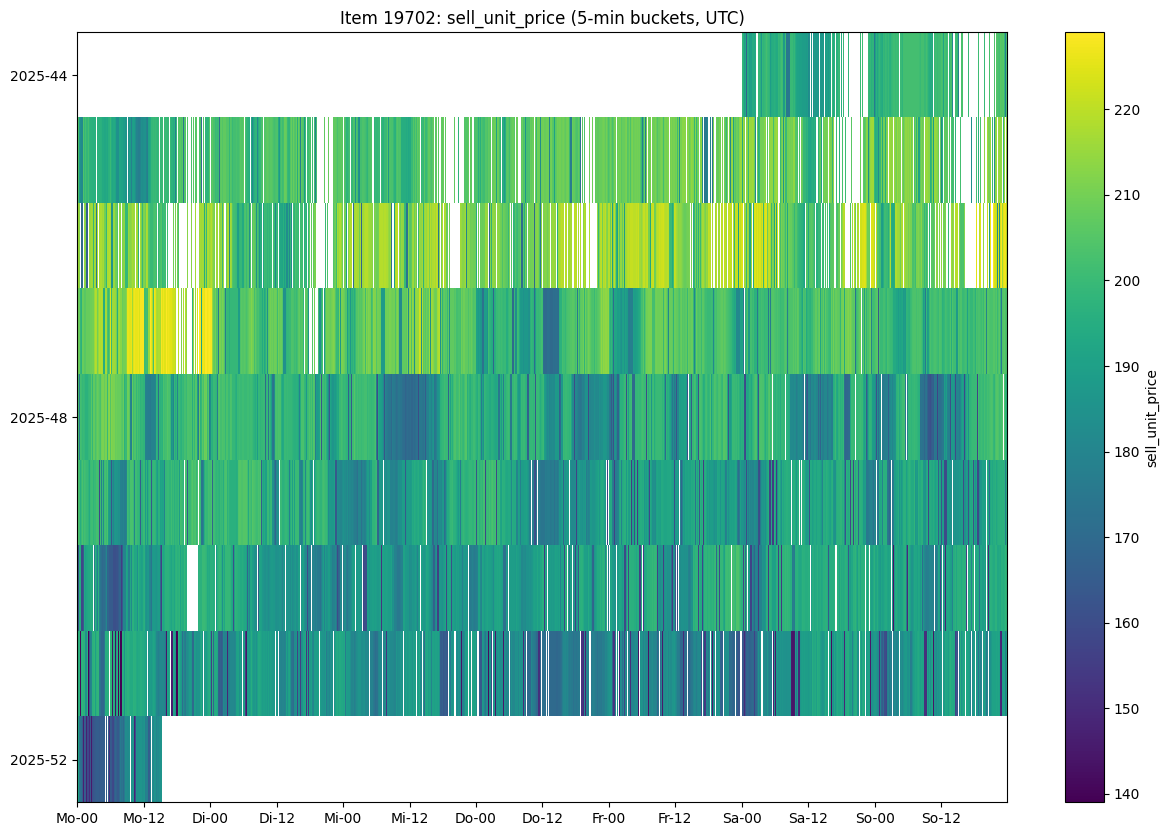

In [ ]:
# weekly heatmaps (implot): one figure per metric on a stable 5-minute UTC grid
import pandas as pd
import matplotlib.pyplot as plt

from gw2ml.evaluation.plot import implot

# --- source data ---
source_df = prices_clean if "prices_clean" in globals() else prices
if "fetched_at" not in source_df.columns:
    raise KeyError("Expected column `fetched_at` in `prices`/`prices_clean`.")

metrics = [
    "buy_quantity",
    "sell_quantity",
    "buy_unit_price",
    "sell_unit_price",
]

missing_metrics = [m for m in metrics if m not in source_df.columns]
if missing_metrics:
    raise KeyError(f"Missing expected metric columns: {missing_metrics}")

# Robust datetime handling (important when loaded from CSV/DB as strings)
df = source_df.copy()
if not pd.api.types.is_datetime64_any_dtype(df["fetched_at"]):
    df["fetched_at"] = pd.to_datetime(df["fetched_at"], utc=True)
elif getattr(df["fetched_at"].dt, "tz", None) is None:
    df["fetched_at"] = df["fetched_at"].dt.tz_localize("UTC")

# --- stable 5-minute grid (single re-usable frame) ---
df = df.sort_values("fetched_at")
df["fetched_at_5m"] = df["fetched_at"].dt.floor("5min")

# One value per 5-minute bucket (take last observed value in that bucket)
df_5m = (
    df.groupby("fetched_at_5m", as_index=True)[metrics]
    .last()
    .sort_index()
)

if len(df_5m.index) < 2:
    raise ValueError("Need at least 2 timestamps to infer frequency for implot().")

# Reindex to a complete 5-minute range so implot() always infers freq=5min
regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", tz=df_5m.index.tz)
df_5m_regular = df_5m.reindex(regular_index)

# --- plot ---
for metric in metrics:
    fig = implot(
        df_5m_regular[metric],
        title=f"Item {ITEM_ID}: {metric} (5-min buckets, UTC)",
        scale=False,
        cmap="viridis",
        label=metric,
    )
    plt.show()


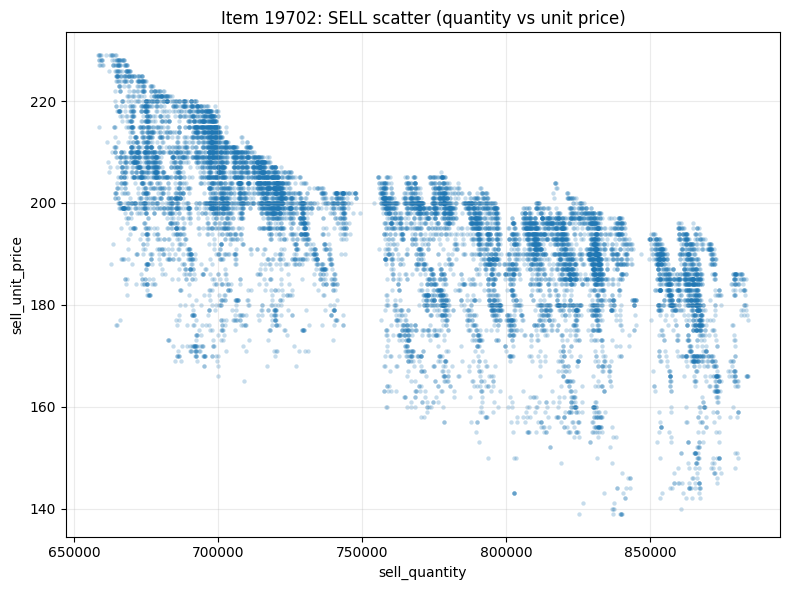

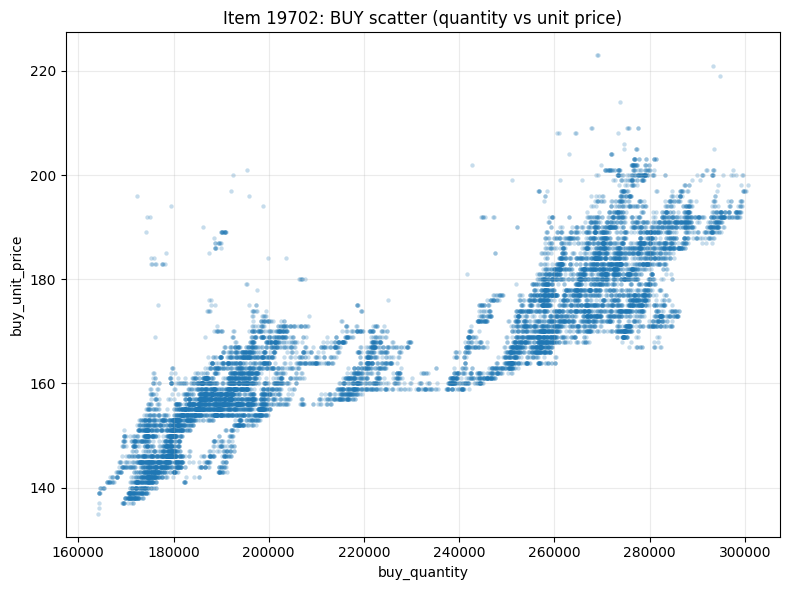

In [ ]:
# scatter plots
import pandas as pd
import matplotlib.pyplot as plt

# Prefer reusing the 5-minute grid from the previous cell if available
required_cols = ["sell_quantity", "sell_unit_price", "buy_quantity", "buy_unit_price"]

if "df_5m_regular" in globals() and all(c in df_5m_regular.columns for c in required_cols):
    scatter_source = df_5m_regular[required_cols].copy()
else:
    # Fallback: rebuild the same stable 5-minute bucketed frame
    source_df = prices_clean if "prices_clean" in globals() else prices
    if "fetched_at" not in source_df.columns:
        raise KeyError("Expected column `fetched_at` in `prices`/`prices_clean`.")

    df = source_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df["fetched_at"]):
        df["fetched_at"] = pd.to_datetime(df["fetched_at"], utc=True)
    elif getattr(df["fetched_at"].dt, "tz", None) is None:
        df["fetched_at"] = df["fetched_at"].dt.tz_localize("UTC")

    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing expected columns for scatter plots: {missing_cols}")

    df = df.sort_values("fetched_at")
    df["fetched_at_5m"] = df["fetched_at"].dt.floor("5min")

    df_5m = (
        df.groupby("fetched_at_5m", as_index=True)[required_cols]
        .last()
        .sort_index()
    )

    if len(df_5m.index) < 2:
        raise ValueError("Need at least 2 timestamps to build scatter plots.")

    regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", tz=df_5m.index.tz)
    scatter_source = df_5m.reindex(regular_index)

scatter_df = scatter_source.dropna(how="any")

# SELL scatter: x=sell_quantity, y=sell_unit_price
fig_sell, ax_sell = plt.subplots(figsize=(8, 6))
ax_sell.scatter(
    scatter_df["sell_quantity"],
    scatter_df["sell_unit_price"],
    s=10,
    alpha=0.25,
    linewidths=0,
)
ax_sell.set_title(f"Item {ITEM_ID}: SELL scatter (quantity vs unit price)")
ax_sell.set_xlabel("sell_quantity")
ax_sell.set_ylabel("sell_unit_price")
ax_sell.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# BUY scatter: x=buy_quantity, y=buy_unit_price
fig_buy, ax_buy = plt.subplots(figsize=(8, 6))
ax_buy.scatter(
    scatter_df["buy_quantity"],
    scatter_df["buy_unit_price"],
    s=10,
    alpha=0.25,
    linewidths=0,
)
ax_buy.set_title(f"Item {ITEM_ID}: BUY scatter (quantity vs unit price)")
ax_buy.set_xlabel("buy_quantity")
ax_buy.set_ylabel("buy_unit_price")
ax_buy.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


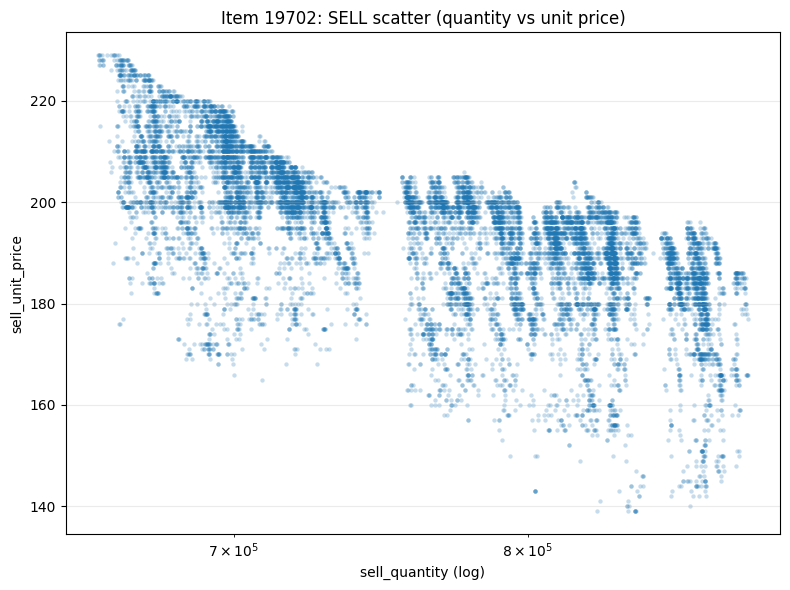

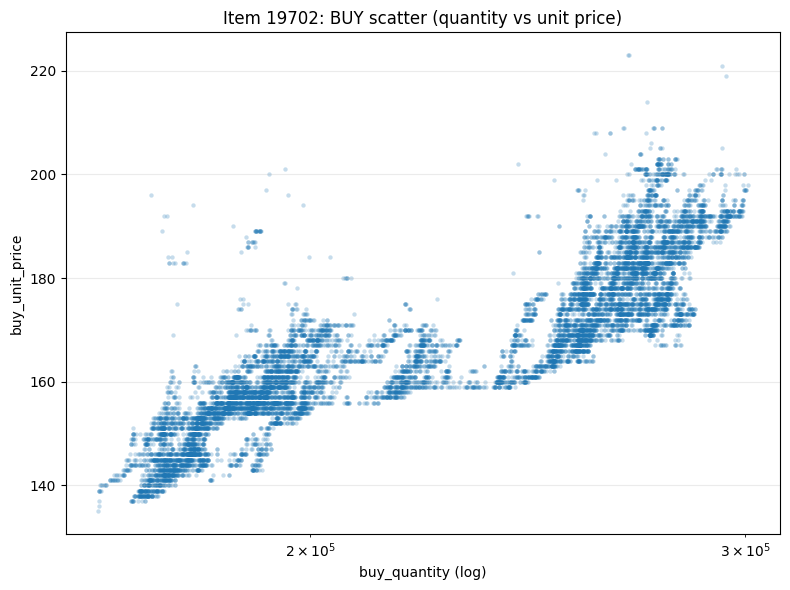

In [ ]:
# scatter plots
import pandas as pd
import matplotlib.pyplot as plt

# Prefer reusing the 5-minute grid from the previous cell if available
required_cols = ["sell_quantity", "sell_unit_price", "buy_quantity", "buy_unit_price"]

if "df_5m_regular" in globals() and all(c in df_5m_regular.columns for c in required_cols):
    scatter_source = df_5m_regular[required_cols].copy()
else:
    # Fallback: rebuild the same stable 5-minute bucketed frame
    source_df = prices_clean if "prices_clean" in globals() else prices
    if "fetched_at" not in source_df.columns:
        raise KeyError("Expected column `fetched_at` in `prices`/`prices_clean`.")

    df = source_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df["fetched_at"]):
        df["fetched_at"] = pd.to_datetime(df["fetched_at"], utc=True)
    elif getattr(df["fetched_at"].dt, "tz", None) is None:
        df["fetched_at"] = df["fetched_at"].dt.tz_localize("UTC")

    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing expected columns for scatter plots: {missing_cols}")

    df = df.sort_values("fetched_at")
    df["fetched_at_5m"] = df["fetched_at"].dt.floor("5min")

    df_5m = (
        df.groupby("fetched_at_5m", as_index=True)[required_cols]
        .last()
        .sort_index()
    )

    if len(df_5m.index) < 2:
        raise ValueError("Need at least 2 timestamps to build scatter plots.")

    regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", tz=df_5m.index.tz)
    scatter_source = df_5m.reindex(regular_index)

scatter_df = scatter_source.dropna(how="any")

# SELL scatter: x=sell_quantity (log), y=sell_unit_price
sell_df = scatter_df.loc[scatter_df["sell_quantity"] > 0].copy()
if sell_df.empty:
    raise ValueError("SELL scatter has no rows with sell_quantity > 0 (required for log x-axis).")

fig_sell, ax_sell = plt.subplots(figsize=(8, 6))
ax_sell.scatter(
    sell_df["sell_quantity"],
    sell_df["sell_unit_price"],
    s=10,
    alpha=0.25,
    linewidths=0,
)
ax_sell.set_xscale("log")
ax_sell.set_title(f"Item {ITEM_ID}: SELL scatter (quantity vs unit price)")
ax_sell.set_xlabel("sell_quantity (log)")
ax_sell.set_ylabel("sell_unit_price")
ax_sell.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# BUY scatter: x=buy_quantity (log), y=buy_unit_price
buy_df = scatter_df.loc[scatter_df["buy_quantity"] > 0].copy()
if buy_df.empty:
    raise ValueError("BUY scatter has no rows with buy_quantity > 0 (required for log x-axis).")

fig_buy, ax_buy = plt.subplots(figsize=(8, 6))
ax_buy.scatter(
    buy_df["buy_quantity"],
    buy_df["buy_unit_price"],
    s=10,
    alpha=0.25,
    linewidths=0,
)
ax_buy.set_xscale("log")
ax_buy.set_title(f"Item {ITEM_ID}: BUY scatter (quantity vs unit price)")
ax_buy.set_xlabel("buy_quantity (log)")
ax_buy.set_ylabel("buy_unit_price")
ax_buy.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


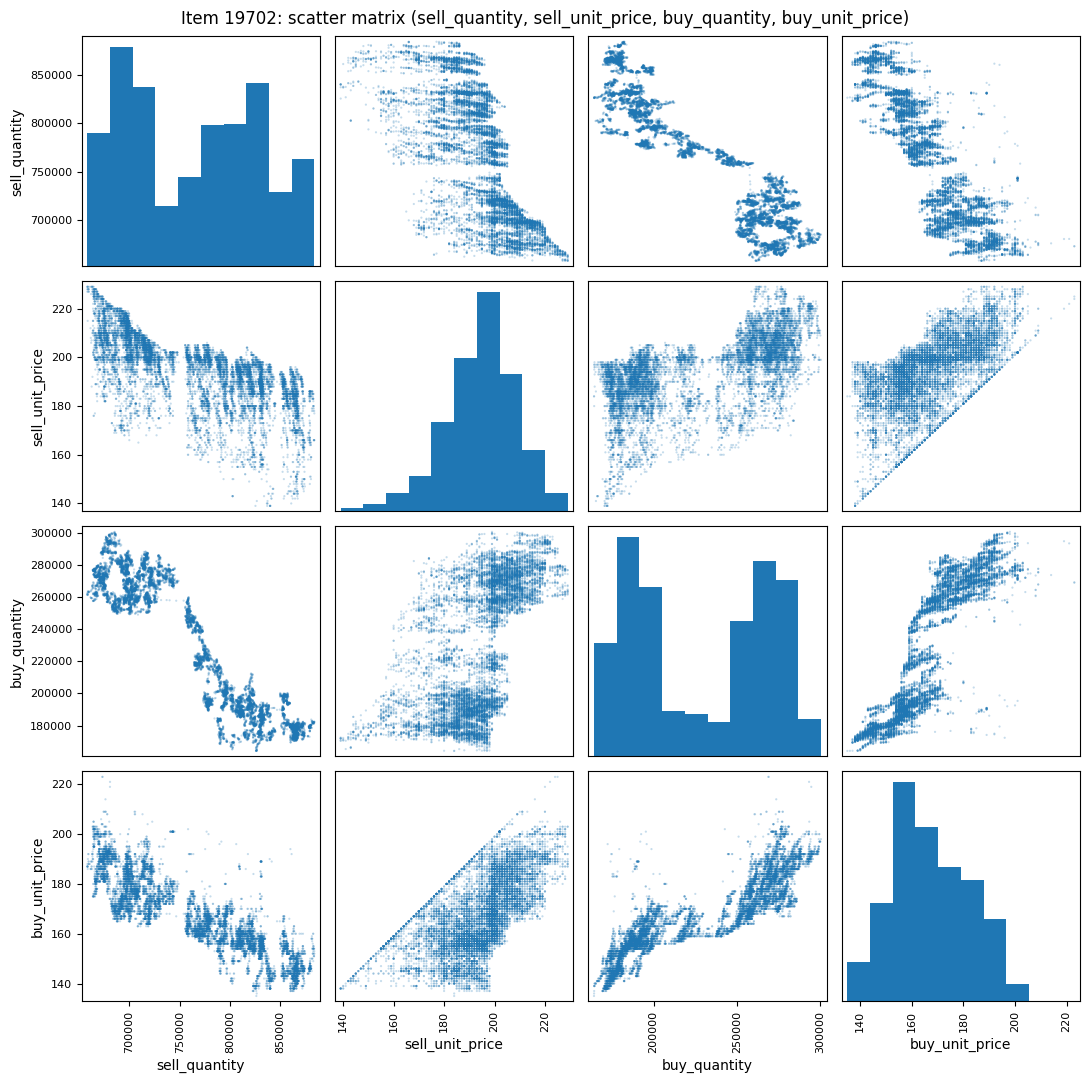

In [ ]:
# scatterplot matrix for each of the metrics
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Metrics to include (same four used above)
metrics = ["sell_quantity", "sell_unit_price", "buy_quantity", "buy_unit_price"]

# Prefer reusing already-prepared scatter_df if available
if "scatter_df" in globals() and isinstance(scatter_df, pd.DataFrame) and all(c in scatter_df.columns for c in metrics):
    matrix_source = scatter_df[metrics].copy()
elif "df_5m_regular" in globals() and isinstance(df_5m_regular, pd.DataFrame) and all(c in df_5m_regular.columns for c in metrics):
    matrix_source = df_5m_regular[metrics].dropna(how="any").copy()
else:
    # Fallback: rebuild the same stable 5-minute bucketed frame
    source_df = prices_clean if "prices_clean" in globals() else prices
    if "fetched_at" not in source_df.columns:
        raise KeyError("Expected column `fetched_at` in `prices`/`prices_clean`.")

    df = source_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df["fetched_at"]):
        df["fetched_at"] = pd.to_datetime(df["fetched_at"], utc=True)
    elif getattr(df["fetched_at"].dt, "tz", None) is None:
        df["fetched_at"] = df["fetched_at"].dt.tz_localize("UTC")

    missing_cols = [c for c in metrics if c not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing expected columns for scatter matrix: {missing_cols}")

    df = df.sort_values("fetched_at")
    df["fetched_at_5m"] = df["fetched_at"].dt.floor("5min")

    df_5m = (
        df.groupby("fetched_at_5m", as_index=True)[metrics]
        .last()
        .sort_index()
    )

    if len(df_5m.index) < 2:
        raise ValueError("Need at least 2 timestamps to build a scatter matrix.")

    regular_index = pd.date_range(df_5m.index.min(), df_5m.index.max(), freq="5min", tz=df_5m.index.tz)
    matrix_source = df_5m.reindex(regular_index).dropna(how="any")

if len(matrix_source.index) < 2:
    raise ValueError("Need at least 2 complete rows (no NaNs) to build a scatter matrix.")

axes = scatter_matrix(
    matrix_source,
    figsize=(11, 11),
    diagonal="hist",
    alpha=0.25,
    s=10,
)

title_item = globals().get("ITEM_ID", "")
plt.suptitle(f"Item {title_item}: scatter matrix ({', '.join(metrics)})" if title_item != "" else f"Scatter matrix ({', '.join(metrics)})")
plt.tight_layout()
plt.show()
